In [1]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import colorlover as cl
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import MinMaxScaler    
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

# Opening
The goal of this pet project is to experiment with building recommendation engines for video games purchases.
The data used are 2 Steam dataset, one of which contains data on users, what games they bought and how many hours they palyed.\
The other contains info on the games, like generes, tags, publishers etc.

The project will is diveded into 3 parts:\
Part 1 is basic yet comprehensive analysis focusing on understanding both datasets, building classification models (which are proto-rec_engines) and playing with basic feature generation.\
In Part 2 we will try to tackle the imbalanced classes problems and generate more features from etxt values\
In Part 3 we will use collaborative filtering to build our recoomender engine

In [2]:
plt.style.use('ggplot')

In [3]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [4]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

## Reading the data

In [6]:
pp_statistics = pd.read_csv('steam-200k.csv', header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])

In [7]:
pp_statistics.head()

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [8]:
pp_statistics.shape

(200000, 5)

In [9]:
all_games = pd.read_csv('steam_games.csv')

In [10]:
all_games.head()

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,game_details,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","Single-player,Multi-player,Co-op,Steam Achieve...","English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99
1,https://store.steampowered.com/app/578080/PLAY...,app,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017",PUBG Corporation,"PUBG Corporation,PUBG Corporation","Survival,Shooter,Multiplayer,Battle Royale,PvP...","Multi-player,Online Multi-Player,Stats","English,Korean,Simplified Chinese,French,Germa...",37.0,"Action,Adventure,Massively Multiplayer",About This Game PLAYERUNKNOWN'S BATTLEGROUND...,Mature Content Description The developers de...,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$29.99,NaN
2,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Single-player,Multi-player,Online Multi-Player...","English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN
3,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...","English,French,Italian,German,Spanish - Spain,...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN
4,https://store.steampowered.com/app/8500/EVE_On...,app,EVE Online,EVE Online is a community-driven spaceship MMO...,"Mixed,(287),- 54% of the 287 user reviews in t...","Mostly Positive,(11,481),- 74% of the 11,481 u...","May 6, 2003",CCP,"CCP,CCP","Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Multi-player,Online Multi-Player,MMO,Co-op,Onl...","English,German,Russian,French",NaN,"Action,Free to Play,Massively Multiplayer,RPG,...",About This Game,NaN,"Minimum:,OS:,Windows 7,Processor:,Intel Dual C...","Recommended:,OS:,Windows 10,Processor:,Intel i...",Free,NaN


# Performing EDA on the first dataset

In [11]:
pp_statistics.loc[pp_statistics['Action'] == 'play'].describe()

,UserID,Hours,Other
count,7.048900e+04,70489.000000,70489.0
mean,1.058812e+08,48.878063,0.0
std,7.150365e+07,229.335236,0.0
min,5.250000e+03,0.100000,0.0
25%,4.934256e+07,1.000000,0.0
50%,9.169067e+07,4.500000,0.0
75%,1.556738e+08,19.100000,0.0
max,3.099031e+08,11754.000000,0.0


In [12]:
users = pp_statistics.groupby(['UserID', 'Action']).size()
users.head()

UserID  Action  
5250    play         6
        purchase    21
76767   play        20
        purchase    36
86540   play        15
dtype: int64

In [13]:
games = pp_statistics.groupby(['Game', 'Action']).size()
games.tail()

Game                       Action  
the static speaks my name  purchase     13
theHunter                  play        124
                           purchase    248
theHunter Primal           play          4
                           purchase      4
dtype: int64

In [14]:
print("Number of games : {0}".format(len(pp_statistics.Game.unique())))
print("Number of users : {0}".format(len(pp_statistics.UserID.unique())))
print("Number of total purchases : {0}".format(len(pp_statistics.loc[pp_statistics['Action'] == 'purchase'])))
print("Number of total plays infos : {0}".format(len(pp_statistics.loc[pp_statistics['Action'] == 'play'])))

Number of games : 5155
Number of users : 12393
Number of total purchases : 129511
Number of total plays infos : 70489


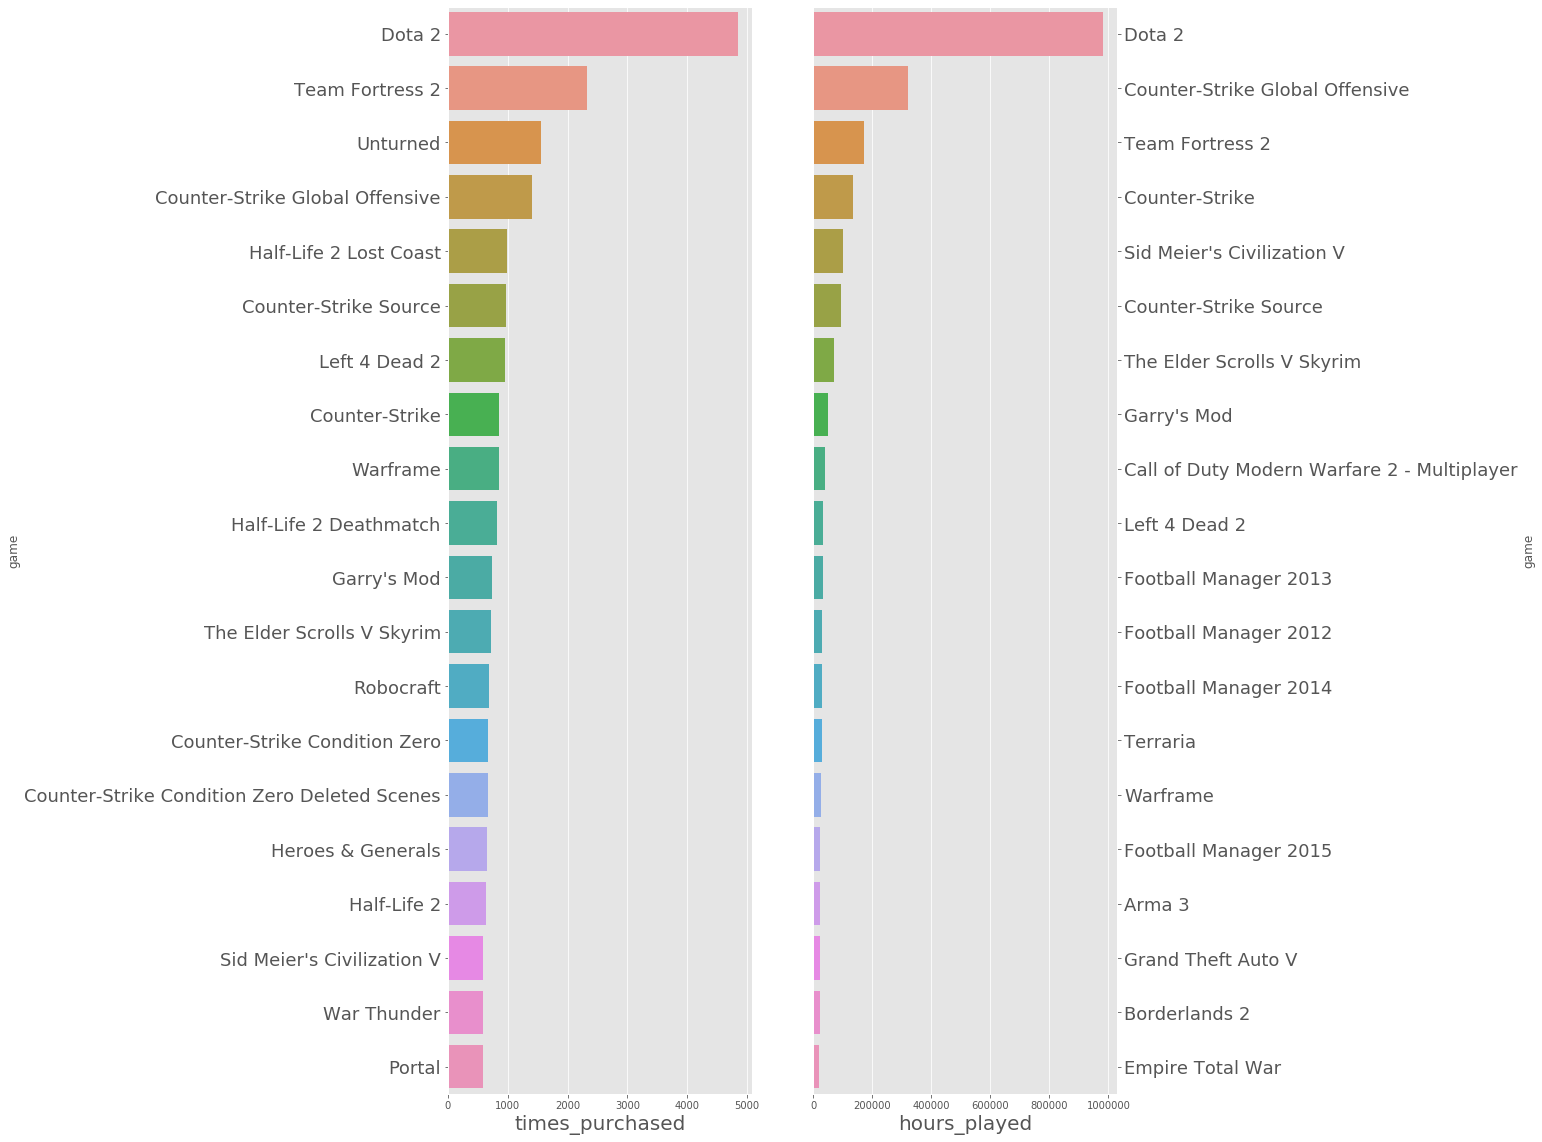

In [15]:
nb_games = 20
df_purchase = pp_statistics.loc[pp_statistics['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

df_play = pp_statistics.loc[pp_statistics['Action'] == 'play']
hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

fig, ax =plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

It is obvious taht people prefer multiplayer action and tactics(? Is Dota 2 tactics RPG?:))

Let's see what games long players prefer

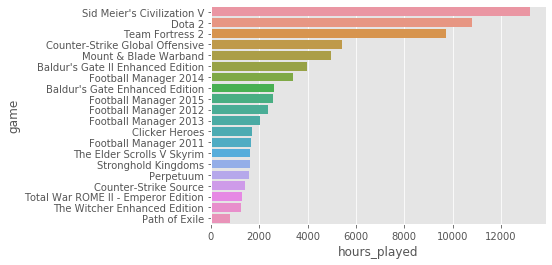

In [17]:
top = 10
user_counts = pp_statistics.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)[0:top]
mask = pp_statistics['UserID'].isin(user_counts.index)
df_infos_user = pp_statistics.loc[mask].loc[pp_statistics['Action'] == 'play']
hours_played = df_infos_user.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

sns.barplot(y = 'game', x = 'hours_played', data = hours_played)

By testing several value for the number of top gamers, we observe some surprising to-played games like CIvilization V being the most played within the top whereas only on the 5th position of the most-played games. Same thing for Mount & Blade Warband, not appearing in the top10 most played games for all users but present in the top with we only keep the most active players. We will now try to observe this distribution of played time for those particular games, and maybe differenciate the famous games played less than some less known games but causing hardcore gaming.

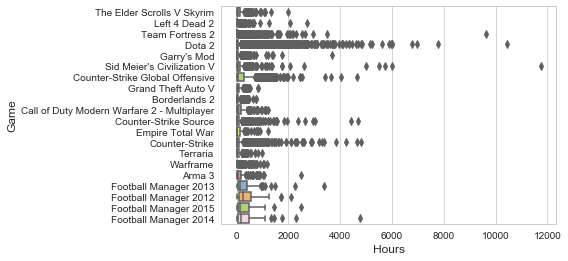

In [18]:
nb_top_games = 20
hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
top_played_games = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_top_games]

mask = pp_statistics['Game'].isin(top_played_games['game'])

df_infos_user = pp_statistics.loc[mask].loc[pp_statistics['Action'] == 'play'][['Hours', 'Game']]


sns.set_style("whitegrid")
sns.boxplot(x="Hours", y="Game", data=df_infos_user, palette="Set3")

As we can see, there are some games staying quite close to the mean played games, whereas some others like FM or Civilization have some vert extremal played times.

## User Classification
In this we will try to find some clusters for users, to determine profile of gamers. To do so, we will try to use :

Nb Purchased Games vs Hours Played
Nb Played Games vs Hours Played
Nb Actions vs Hours Played

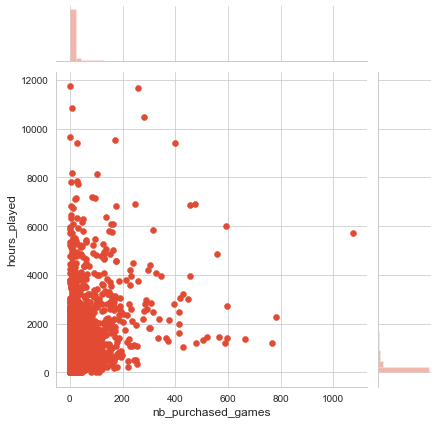

In [19]:
df_purchased_games = pp_statistics.loc[pp_statistics['Action'] == 'purchase']
df_played_games = pp_statistics.loc[pp_statistics['Action'] == 'play']

#here we compute the number of games a user has bought
user_counts = df_purchased_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_purchased_games = pd.DataFrame({'UserID': user_counts.index, 'nb_purchased_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})

#merge to have one entry per user with number of hours played and number of purchased games
data = pd.merge(user_df_purchased_games, user_df_hours_played, on='UserID')
sns.jointplot(x="nb_purchased_games", y="hours_played", data=data)# , kind="reg")

Not very insightful. Let's put some log

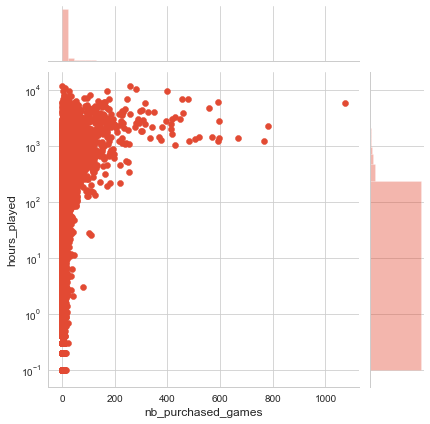

In [20]:
g = sns.jointplot(x="nb_purchased_games", y="hours_played", data=data )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

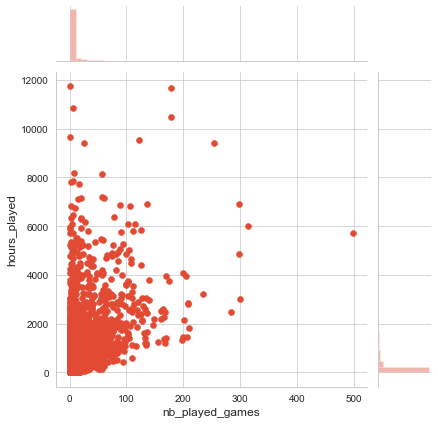

In [21]:
#here we compute the number of games a user has played
user_counts = df_played_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_played_games = pd.DataFrame({'UserID': user_counts.index, 'nb_played_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})


#merge to have one entry per user with number of hours played and number of played games
data = pd.merge(user_df_played_games, user_df_hours_played, on='UserID')

sns.jointplot(x="nb_played_games", y="hours_played", data=data )# , kind="reg")

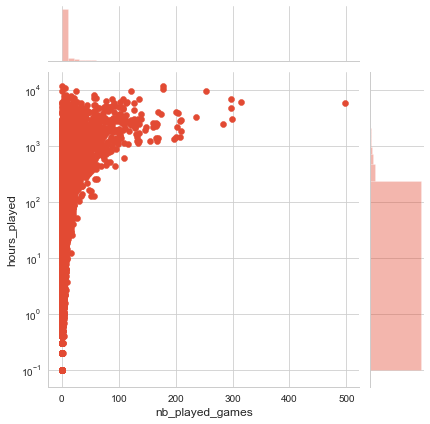

In [22]:
g = sns.jointplot(x="nb_played_games", y="hours_played", data=data )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

Too much noise in the dataset, we should try to eliminate those absurd values to focus more precisely on the core of the points.

In [23]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [24]:
df_out = remove_outlier(pp_statistics, 'Hours')

Let's recalculate after removing the outliers

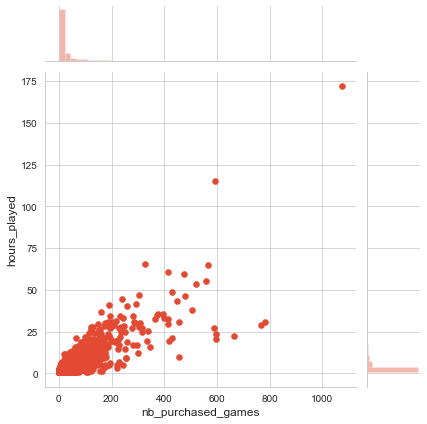

In [26]:
df_purchased_games = df_out.loc[df_out['Action'] == 'purchase']
df_played_games = df_out.loc[df_out['Action'] == 'play']

#here we compute the number of games a user has bought
user_counts = df_purchased_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_purchased_games = pd.DataFrame({'UserID': user_counts.index, 'nb_purchased_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})

#merge to have one entry per user with number of hours played and number of purchased games
data = pd.merge(user_df_purchased_games, user_df_hours_played, on='UserID')
sns.jointplot(x="nb_purchased_games", y="hours_played", data=data)# , kind="reg")

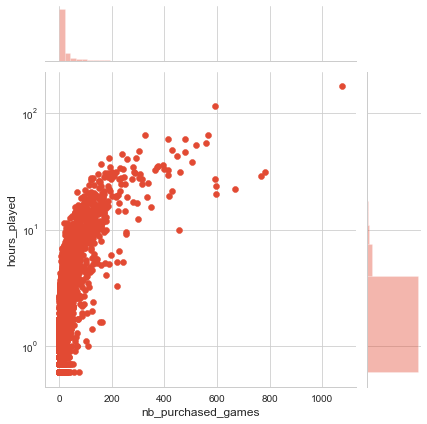

In [27]:
g = sns.jointplot(x="nb_purchased_games", y="hours_played", data=data )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

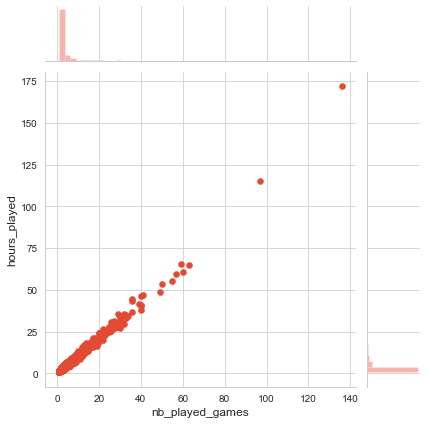

In [28]:
#here we compute the number of games a user has played
user_counts = df_played_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_played_games = pd.DataFrame({'UserID': user_counts.index, 'nb_played_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})


#merge to have one entry per user with number of hours played and number of played games
data = pd.merge(user_df_played_games, user_df_hours_played, on='UserID')

sns.jointplot(x="nb_played_games", y="hours_played", data=data )# , kind="reg")

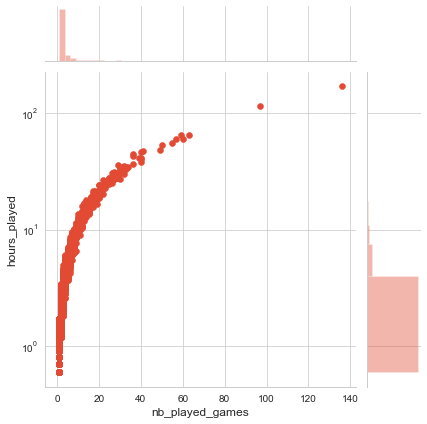

In [29]:
g = sns.jointplot(x="nb_played_games", y="hours_played", data=data )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

Now we see something! Let's build some clusters

In [30]:
from sklearn.cluster import KMeans

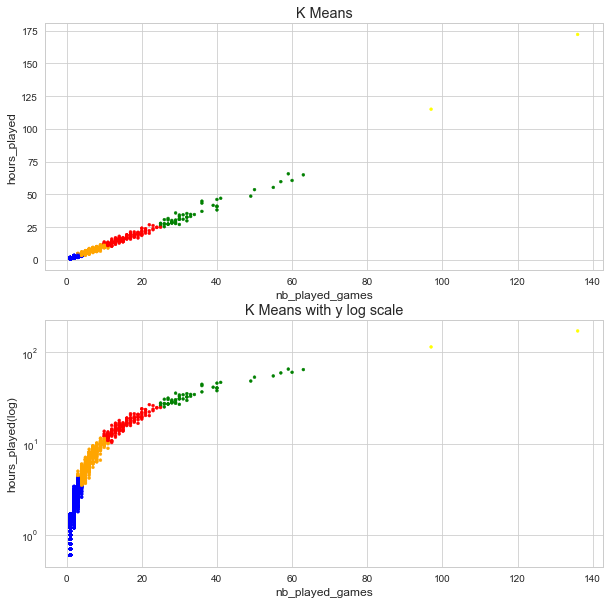

In [31]:
# K Means
temp = data.copy()
del temp['UserID'] #don't need this for k mean

N_CLUSTERS = 5
train_data = temp.values
# Using sklearn
km = KMeans(n_clusters=N_CLUSTERS)
km.fit(train_data)
# Get cluster assignment labels
labels = km.labels_ # 0 to n_clusters-1
# Format results as a DataFrame

LABEL_COLOR_MAP = {0 : 'red',
                   1 : 'blue',
                   2 : 'green',
                   3 : 'yellow',
                   4 : 'orange',
                   5 : 'pink'
                  }

label_color = [LABEL_COLOR_MAP[l] for l in labels]


fig, ax =plt.subplots(2,1,figsize=(10,10))
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_played_games')
ax[0].set_ylabel('hours_played')
ax[0].set_title('K Means')

ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_played_games')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('K Means with y log scale')
ax[1].set_yscale('log')

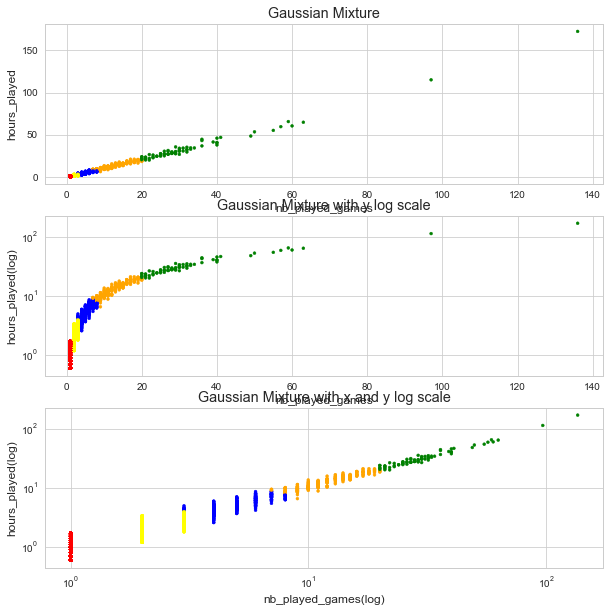

In [32]:
from sklearn.mixture import GaussianMixture
cov_types = ['spherical', 'diag', 'tied', 'full']

gm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag')
gm.fit(train_data)
y_train_pred = gm.predict(train_data)
label_color = [LABEL_COLOR_MAP[l] for l in y_train_pred]

fig, ax =plt.subplots(3,1,figsize=(10,10))
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_played_games')
ax[0].set_ylabel('hours_played')
ax[0].set_title('Gaussian Mixture')

ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_played_games')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('Gaussian Mixture with y log scale')
ax[1].set_yscale('log')

ax[2].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[2].set_xlabel('nb_played_games(log)')
ax[2].set_ylabel('hours_played(log)')
ax[2].set_title('Gaussian Mixture with x and y log scale')
ax[2].set_yscale('log')
ax[2].set_xscale('log')

Clusters (surprisnigly enough:)) are clearly seen, especially after removing the ouliers. 

Let's test our reuslts by drawing the correlation matrix

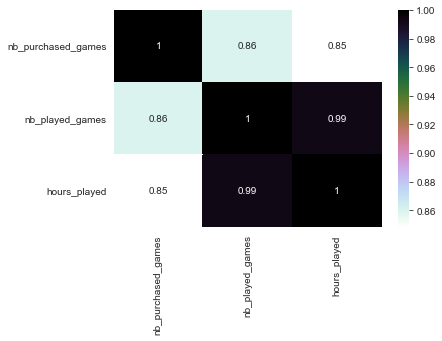

In [33]:
temp = pd.merge(user_df_purchased_games, data, on='UserID')
temp = temp.copy()
del temp['UserID'] #don't need this for k mean
sns.heatmap(temp.corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlation

Logically, we have a strong correlation between the number of played games and the number of purchased games

Now let's perfrom same actions, but on games. We will (probably) need this in our recommendation engine in the future

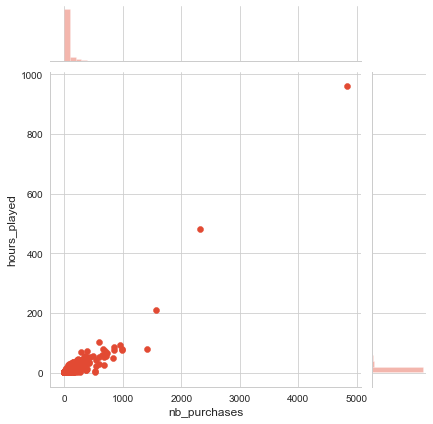

In [34]:
df_purchased_games = df_out.loc[df_out['Action'] == 'purchase']
df_played_games = df_out.loc[df_out['Action'] == 'play']

#here we compute the number of games a user has bought
games_counts = df_purchased_games.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
game_df_purchased_games = pd.DataFrame({'Game': games_counts.index, 'nb_purchases': games_counts.values})
game_df_hours_played = pd.DataFrame({'Game': hours_played.index, 'hours_played': hours_played.values})

#merge to have one entry per user with number of hours played and number of purchased games
data_games = pd.merge(game_df_purchased_games, game_df_hours_played, on='Game')
sns.jointplot(x="nb_purchases", y="hours_played", data=data_games)# , kind="reg")

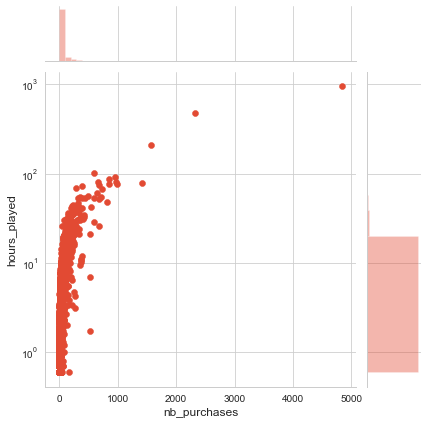

In [35]:
g = sns.jointplot(x="nb_purchases", y="hours_played", data=data_games )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

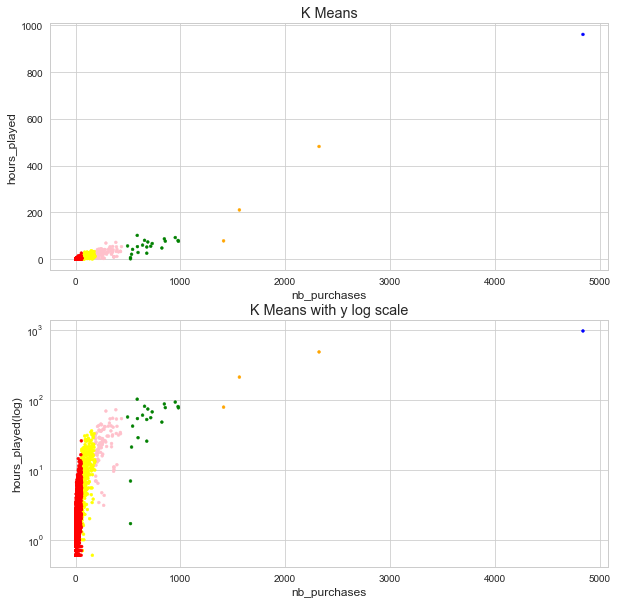

In [36]:
# K Means
temp = data_games.copy()
del temp['Game'] #don't need this for k mean

N_CLUSTERS = 6
train_data = temp.values
# Using sklearn
km = KMeans(n_clusters=N_CLUSTERS)
km.fit(train_data)
# Get cluster assignment labels
labels = km.labels_ # 0 to n_clusters-1
# Format results as a DataFrame

LABEL_COLOR_MAP = {0 : 'red',
                   1 : 'blue',
                   2 : 'green',
                   3 : 'yellow',
                   4 : 'orange',
                   5 : 'pink'
                  }

label_color = [LABEL_COLOR_MAP[l] for l in labels]


fig, ax =plt.subplots(2,1,figsize=(10,10))
ax[0].scatter(data_games[['nb_purchases']], data_games[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_purchases')
ax[0].set_ylabel('hours_played')
ax[0].set_title('K Means')

ax[1].scatter(data_games[['nb_purchases']], data_games[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_purchases')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('K Means with y log scale')
ax[1].set_yscale('log')

Ok, so we see interesting clusters: red - games bought much less, than others, but with a big number of hours played. Could be niche but very good games for tehir fans....and so on. There is one outlier, which was both bought and palyed A LOT - that's DOTA. And we have some interesting points in pink cluster - games baught a lot, but number of hours played is quite low - most probably big names which suck :)

Let's move to the second dataset

# EDA on second dataset

## Data cleaning and preparation

In [39]:
all_games.head()

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,game_details,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","Single-player,Multi-player,Co-op,Steam Achieve...","English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99
1,https://store.steampowered.com/app/578080/PLAY...,app,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017",PUBG Corporation,"PUBG Corporation,PUBG Corporation","Survival,Shooter,Multiplayer,Battle Royale,PvP...","Multi-player,Online Multi-Player,Stats","English,Korean,Simplified Chinese,French,Germa...",37.0,"Action,Adventure,Massively Multiplayer",About This Game PLAYERUNKNOWN'S BATTLEGROUND...,Mature Content Description The developers de...,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$29.99,NaN
2,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Single-player,Multi-player,Online Multi-Player...","English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN
3,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...","English,French,Italian,German,Spanish - Spain,...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN
4,https://store.steampowered.com/app/8500/EVE_On...,app,EVE Online,EVE Online is a community-driven spaceship MMO...,"Mixed,(287),- 54% of the 287 user reviews in t...","Mostly Positive,(11,481),- 74% of the 11,481 u...","May 6, 2003",CCP,"CCP,CCP","Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Multi-player,Online Multi-Player,MMO,Co-op,Onl...","English,German,Russian,French",NaN,"Action,Free to Play,Massively Multiplayer,RPG,...",About This Game,NaN,"Minimum:,OS:,Windows 7,Processor:,Intel Dual C...","Recommended:,OS:,Windows 10,Processor:,Intel i...",Free,NaN


Let's remove unnessary columns for the sake of the ease of teh future analysis

In [40]:
temp1 = all_games.drop(['url','types','mature_content','languages', 'minimum_requirements', 
                        'recommended_requirements', 'release_date'], axis = 1)

In [41]:
all_games['types'].value_counts()

app       38021
bundle     2572
sub         238
Name: types, dtype: int64

In [42]:
temp1.head()

,name,desc_snippet,recent_reviews,all_reviews,developer,publisher,popular_tags,game_details,achievements,genre,game_description,original_price,discount_price
0,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","Single-player,Multi-player,Co-op,Steam Achieve...",54.0,Action,"About This Game Developed by id software, the...",$19.99,$14.99
1,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...",PUBG Corporation,"PUBG Corporation,PUBG Corporation","Survival,Shooter,Multiplayer,Battle Royale,PvP...","Multi-player,Online Multi-Player,Stats",37.0,"Action,Adventure,Massively Multiplayer",About This Game PLAYERUNKNOWN'S BATTLEGROUND...,$29.99,NaN
2,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Single-player,Multi-player,Online Multi-Player...",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,$39.99,NaN
3,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,$44.99,NaN
4,EVE Online,EVE Online is a community-driven spaceship MMO...,"Mixed,(287),- 54% of the 287 user reviews in t...","Mostly Positive,(11,481),- 74% of the 11,481 u...",CCP,"CCP,CCP","Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Multi-player,Online Multi-Player,MMO,Co-op,Onl...",NaN,"Action,Free to Play,Massively Multiplayer,RPG,...",About This Game,Free,NaN


Let's split reviews data, publisher by n=1 grams using "," as a delimeter

In [43]:
temp1['recent_reviews'] = temp1['recent_reviews'].str.split(',', expand = True)
temp1['all_reviews'] = temp1['all_reviews'].str.split(',', expand = True)
temp1['publisher'] = temp1['publisher'].str.split(',', expand = True)

Let's convert NaNs in achievemnts to 0

In [45]:
temp1['achievements'] = temp1['achievements'].fillna(0)

With discounted price it is trickier. If we see NaN, it measns that there was no discount. 
It is potentially an importnat feature, let's preserve it

Then we should convert prices in USD to integers

NB! The dataset is VERY dirty, there more than a hundred values in the price column which are actually text, sometimes in chinese and Herbrew. Taht is why we use errorc = 'coerece' parameter here - to jsu replace them with NaNs

In [48]:
temp1['original_price'] = pd.to_numeric(temp1['original_price'].str.strip('$'), errors='coerce').fillna(0.0)

Same for discounted price

In [50]:
temp1['discount_price'] = pd.to_numeric(temp1['discount_price'].str.strip('$'), errors='coerce').fillna(0.0)

Now lets split popular tags, game_details and genre, keeping only top 5 values (top3 in case of genre)

In [52]:
temp2 = temp1.join(temp1['popular_tags'].str.split(',', expand=True).add_prefix('tag')).drop(['tag5','tag6', 'tag7', 'tag8',
                                                                                             'tag9', 'tag10', 'tag11', 'tag12',
                                                                                             'tag13', 'tag14', 'tag15', 'tag16',
                                                                                             'tag17', 
                                                                                              'tag18', 'tag19'], axis =1).fillna(value='nan')

In [53]:
temp2.drop(['popular_tags'], axis =1, inplace = True)

In [54]:
temp3 = temp2.join(temp2['game_details'].str.split(',', expand=True).add_prefix('detail')).drop(['detail5', 'detail6', 'detail7',
                                                                                                'detail8','detail9', 'detail10', 
                                                                                                 'detail11', 'detail12', 'detail13',
                                                                                                'detail14', 'detail15',
                                                                                                'detail16', 'detail17', 'detail18',
                                                                                                'detail19', 'detail20',
                                                                                                'detail21'], axis = 1).fillna(value ='nan')

In [55]:
temp3.drop(['game_details'], axis = 1, inplace = True)

In [56]:
temp4 = temp3.join(temp3['genre'].str.split(',', expand=True).add_prefix('genre')).drop(['genre3', 'genre4', 'genre5', 'genre6', 
                                                                                        'genre7', 'genre8', 'genre9', 'genre10',
                                                                                        'genre11', 
                                                                                         'genre12', 'genre13'], axis = 1).fillna(value='nan')

In [57]:
temp4.drop(['genre'], axis = 1, inplace = True)

Time for some memory cleaning

In [59]:
del temp1

In [60]:
del temp2

In [61]:
del temp3

In [62]:
temp4.head()

,name,desc_snippet,recent_reviews,all_reviews,developer,publisher,achievements,game_description,original_price,discount_price,...,tag3,tag4,detail0,detail1,detail2,detail3,detail4,genre0,genre1,genre2
0,DOOM,Now includes all three premium DLC packs (Unto...,Very Positive,Very Positive,id Software,Bethesda Softworks,54.0,"About This Game Developed by id software, the...",19.99,14.99,...,Demons,Shooter,Single-player,Multi-player,Co-op,Steam Achievements,Steam Trading Cards,Action,nan,nan
1,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,Mixed,Mixed,PUBG Corporation,PUBG Corporation,37.0,About This Game PLAYERUNKNOWN'S BATTLEGROUND...,29.99,0.00,...,Battle Royale,PvP,Multi-player,Online Multi-Player,Stats,nan,nan,Action,Adventure,Massively Multiplayer
2,BATTLETECH,Take command of your own mercenary outfit of '...,Mixed,Mostly Positive,Harebrained Schemes,Paradox Interactive,128.0,About This Game From original BATTLETECH/Mec...,39.99,0.00,...,Turn-Based Tactics,Sci-fi,Single-player,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Action,Adventure,Strategy
3,DayZ,The post-soviet country of Chernarus is struck...,Mixed,Mixed,Bohemia Interactive,Bohemia Interactive,0.0,About This Game The post-soviet country of Ch...,44.99,0.00,...,Multiplayer,PvP,Multi-player,Online Multi-Player,Steam Workshop,Steam Cloud,Valve Anti-Cheat enabled,Action,Adventure,Massively Multiplayer
4,EVE Online,EVE Online is a community-driven spaceship MMO...,Mixed,Mostly Positive,CCP,CCP,0.0,About This Game,0.00,0.00,...,Sandbox,MMORPG,Multi-player,Online Multi-Player,MMO,Co-op,Online Co-op,Action,Free to Play,Massively Multiplayer


Spoiler alert: as a baseilne for our recommender engine we will use Catboost classifier, which does not recquire OHE in teh preprocessing, so we will not use it

## Feature extarction and feature generation

Numerical features: prices into buckets, than buckets to categories; is there a discount? What % is the discount, achievemnts into buckets than to categories

In [65]:
bins_price = [0, 1, 5, 10, 15, 30, 50, 100, 1001]
labels_price =['Free','Under 5 USD','Under 10 USD','Under 15 USD', 'Under 30 USD', 'Under 50 USD', 'Under 100 USD', "Under 1000 USD"]
temp4['binned_price'] = pd.cut(temp4['original_price'], bins_price,labels=labels_price, include_lowest = True)

In [66]:
temp4['binned_price'].value_counts()

Under 5 USD       12254
Free              11912
Under 10 USD       7872
Under 30 USD       3743
Under 15 USD       3019
Under 50 USD        890
Under 100 USD       599
Under 1000 USD      542
Name: binned_price, dtype: int64

In [67]:
temp4['discount'] = 100 - (temp4['discount_price'] / temp4['original_price']*100).fillna(0)

In [68]:
temp4['discount'].replace([100], [0])

0        25.012506
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
40828     0.000000
40829     0.000000
40830     0.000000
40831     0.000000
40832    43.887776
Name: discount, Length: 40833, dtype: float64

In [69]:
bins_discount = [0,1,25,50,75,101]

In [70]:
labels_discount =['No discount', 'Up to 25%', "Up to 50%", 'Up to 75%', 'Up to 100%']

In [71]:
temp4['binned_discount'] = pd.cut(temp4['discount_price'], bins_discount,labels=labels_discount, include_lowest = True)

In [72]:
temp4['binned_discount'].value_counts()

No discount    26743
Up to 25%       8010
Up to 50%       2898
Up to 75%       1249
Up to 100%       559
Name: binned_discount, dtype: int64

In [73]:
bins_achievements = [0,1,5,10,15,20,50,100,1000]

In [74]:
labels_achievements = ['No achievemnts', 'Up to 5 achievements', 'Up to 10 achievements', 'Up to 15 achievemnts', 
                      'Up to 20 achievemnts', 'Up to 50 achivements', 'Up to 100 achivements', 'Up to 1000 achievemnets']

In [75]:
temp4['binned_achievements'] = pd.cut(temp4['discount_price'], bins_achievements,labels=labels_achievements, include_lowest = True)

In [76]:
temp4['binned_achievements'].value_counts()

No achievemnts             26743
Up to 50 achivements        3997
Up to 10 achievements       2014
Up to 15 achievemnts        1797
Up to 100 achivements       1794
Up to 5 achievements        1728
Up to 1000 achievemnets     1388
Up to 20 achievemnts        1372
Name: binned_achievements, dtype: int64

Let's build a basic classifier

Let's see Cramer's correlation between categorical features

In [79]:
import scipy.stats as ss

In [80]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [81]:
temp5 = temp4.drop(['desc_snippet', 'game_description', 'original_price', 'discount_price', 'achievements', 'discount'], axis = 1)

In [82]:
dicount_all_reviews = cramers_v(temp5['binned_discount'], temp5['all_reviews'])

In [83]:
dicount_all_reviews

0.07624623486718254

In [84]:
dicount_recent_reviews = cramers_v(temp5['binned_discount'], temp5['recent_reviews'])

In [85]:
dicount_recent_reviews

0.049251485502070785

In [86]:
temp5['all_reviews'].value_counts()

nan                        12363
Mixed                       4680
Very Positive               4539
Positive                    3551
Mostly Positive             3311
1 user reviews              3023
2 user reviews              1926
3 user reviews              1469
4 user reviews              1082
5 user reviews               948
6 user reviews               838
Mostly Negative              782
7 user reviews               693
8 user reviews               600
9 user reviews               528
Overwhelmingly Positive      321
Negative                     135
Very Negative                 37
Overwhelmingly Negative        7
Name: all_reviews, dtype: int64

Let's drop irrelevant reviews categories

In [88]:
reviews_to_keep = ['Mixed', 'Very Positive', 'Positive', 'Mostly Positive', 
                  'Mostly Negative', 'Overwhelmingly Positive', 'Negative', 'Very Negative',
                  'Overwhelmingly Negative']

In [89]:
temp5['all_reviews'] = temp4['all_reviews'][temp4.all_reviews.isin(reviews_to_keep)]

In [90]:
temp5['all_reviews'].value_counts()

Mixed                      4680
Very Positive              4539
Positive                   3551
Mostly Positive            3311
Mostly Negative             782
Overwhelmingly Positive     321
Negative                    135
Very Negative                37
Overwhelmingly Negative       7
Name: all_reviews, dtype: int64

In [91]:
all_reviews_recent_reviews = cramers_v(temp5['all_reviews'], temp5['recent_reviews'])
all_reviews_recent_reviews

0.25968884227357447

In [92]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [93]:
from matplotlib import rcParams

In [94]:
rcParams['figure.figsize'] = 11.7,8.27

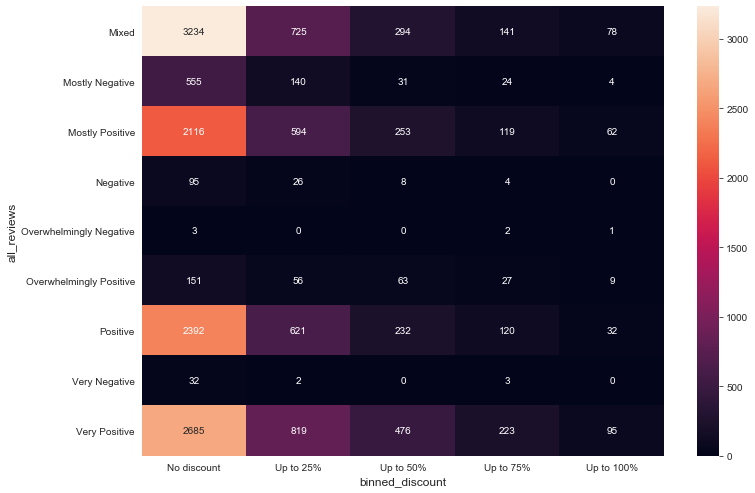

In [95]:
sns.heatmap(pd.crosstab([temp5.all_reviews], [temp5.binned_discount]), annot=True, cbar=True, fmt = 'g')

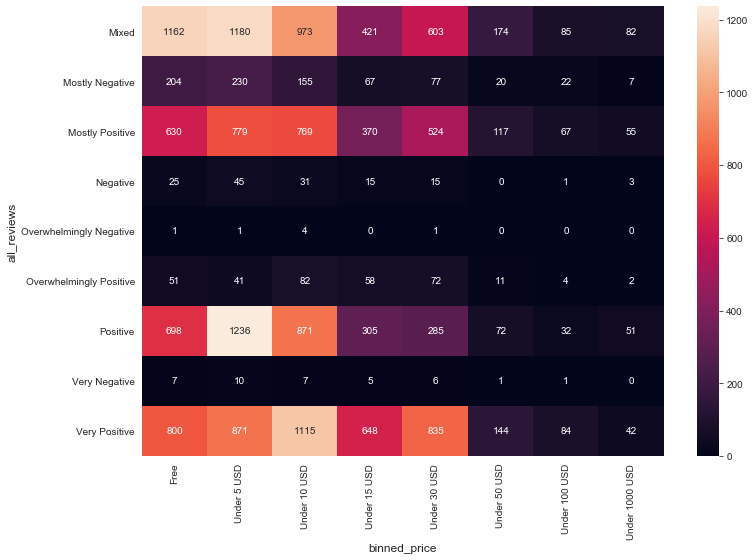

In [96]:
sns.heatmap(pd.crosstab([temp5.all_reviews], [temp5.binned_price]), annot=True, cbar=True, fmt = 'g')

In [97]:
pd.set_option("display.max_columns", 100)

In [98]:
temp5['genre0'].value_counts()

Action                   16290
Adventure                 6854
Casual                    6348
Indie                     4364
Simulation                2074
Strategy                  1099
RPG                        927
Free to Play               577
Racing                     474
Design & Illustration      471
nan                        438
Animation & Modeling       231
Utilities                  159
Audio Production           122
Sports                      86
Education                   83
Violent                     44
Massively Multiplayer       39
Web Publishing              35
Video Production            25
Sexual Content              23
Software Training           21
Nudity                      14
Photo Editing                9
Accounting                   6
Early Access                 6
Valve                        4
Movie                        3
Gore                         3
Game Development             2
Short                        1
HTC                          1
Name: ge

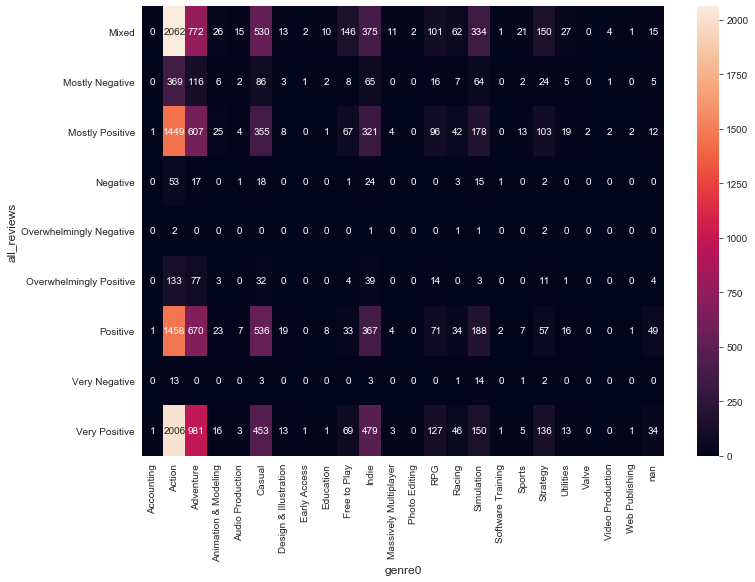

In [99]:
sns.heatmap(pd.crosstab([temp5.all_reviews], [temp5.genre0]), annot=True, cbar=True, fmt = 'g')

In [100]:
temp5['tag0'].value_counts()

Action               7970
Indie                5436
Strategy             4040
Adventure            3745
Casual               3504
                     ... 
Top-Down Shooter        1
Trading Card Game       1
Turn-Based Combat       1
Mod                     1
Voxel                   1
Name: tag0, Length: 237, dtype: int64

In [101]:
genre0_tag0 = cramers_v(temp5['genre0'], temp5['tag0'])

In [102]:
genre0_tag0

0.49362736090018694

In [103]:
genre1_tag1 = cramers_v(temp5['genre1'], temp5['tag1'])

In [104]:
genre1_tag1

0.3875675390729988

In [105]:
genre2_tag2 = cramers_v(temp5['genre2'], temp5['tag2'])

In [106]:
genre2_tag2

0.32308008273633926

We see a big correlation bewteen genres and tag values, decreasing towards the more "distant" values in the list\
Let's drop first 3 tags as most correlating, also, let's leave only one target feature - all_reviews, as well as game's name\
We will take it back when we will work with text features

In [108]:
df_cbc = temp5.drop(['tag0', 'tag1', 'tag2', 'recent_reviews', 'name'], axis = 1)

In [109]:
df_cbc

,all_reviews,developer,publisher,tag3,tag4,detail0,detail1,detail2,detail3,detail4,genre0,genre1,genre2,binned_price,binned_discount,binned_achievements
0,Very Positive,id Software,Bethesda Softworks,Demons,Shooter,Single-player,Multi-player,Co-op,Steam Achievements,Steam Trading Cards,Action,nan,nan,Under 30 USD,Up to 25%,Up to 15 achievemnts
1,Mixed,PUBG Corporation,PUBG Corporation,Battle Royale,PvP,Multi-player,Online Multi-Player,Stats,nan,nan,Action,Adventure,Massively Multiplayer,Under 30 USD,No discount,No achievemnts
2,Mostly Positive,Harebrained Schemes,Paradox Interactive,Turn-Based Tactics,Sci-fi,Single-player,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Action,Adventure,Strategy,Under 50 USD,No discount,No achievemnts
3,Mixed,Bohemia Interactive,Bohemia Interactive,Multiplayer,PvP,Multi-player,Online Multi-Player,Steam Workshop,Steam Cloud,Valve Anti-Cheat enabled,Action,Adventure,Massively Multiplayer,Under 50 USD,No discount,No achievemnts
4,Mostly Positive,CCP,CCP,Sandbox,MMORPG,Multi-player,Online Multi-Player,MMO,Co-op,Online Co-op,Action,Free to Play,Massively Multiplayer,Free,No discount,No achievemnts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40828,NaN,Ubisoft - San Francisco,nan,nan,nan,Single-player,Shared/Split Screen,Downloadable Content,Steam Achievements,Steam Trading Cards,Casual,Simulation,nan,Under 5 USD,No discount,No achievemnts
40829,NaN,Ubisoft - San Francisco,nan,nan,nan,Single-player,Shared/Split Screen,Downloadable Content,Steam Achievements,Steam Trading Cards,Casual,Simulation,nan,Under 5 USD,No discount,No achievemnts
40830,NaN,"SmiteWorks USA, LLC",nan,Software,Turn-Based,Multi-player,Co-op,Cross-Platform Multiplayer,Downloadable Content,nan,Indie,RPG,Strategy,Under 10 USD,No discount,No achievemnts
40831,NaN,"CAPCOM CO., LTD",CAPCOM CO.,nan,nan,Single-player,Downloadable Content,Steam Achievements,Full controller support,Steam Trading Cards,Action,nan,nan,Under 10 USD,No discount,No achievemnts


let's remove NaNs from target variable

In [111]:
df_cbc.dropna(subset = ["all_reviews"], inplace=True)

In [112]:
df_cbc

,all_reviews,developer,publisher,tag3,tag4,detail0,detail1,detail2,detail3,detail4,genre0,genre1,genre2,binned_price,binned_discount,binned_achievements
0,Very Positive,id Software,Bethesda Softworks,Demons,Shooter,Single-player,Multi-player,Co-op,Steam Achievements,Steam Trading Cards,Action,nan,nan,Under 30 USD,Up to 25%,Up to 15 achievemnts
1,Mixed,PUBG Corporation,PUBG Corporation,Battle Royale,PvP,Multi-player,Online Multi-Player,Stats,nan,nan,Action,Adventure,Massively Multiplayer,Under 30 USD,No discount,No achievemnts
2,Mostly Positive,Harebrained Schemes,Paradox Interactive,Turn-Based Tactics,Sci-fi,Single-player,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Action,Adventure,Strategy,Under 50 USD,No discount,No achievemnts
3,Mixed,Bohemia Interactive,Bohemia Interactive,Multiplayer,PvP,Multi-player,Online Multi-Player,Steam Workshop,Steam Cloud,Valve Anti-Cheat enabled,Action,Adventure,Massively Multiplayer,Under 50 USD,No discount,No achievemnts
4,Mostly Positive,CCP,CCP,Sandbox,MMORPG,Multi-player,Online Multi-Player,MMO,Co-op,Online Co-op,Action,Free to Play,Massively Multiplayer,Free,No discount,No achievemnts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40557,Positive,Team Ninja Thumbs,Team Ninja Thumbs,Local Multiplayer,Fighting,Single-player,Multi-player,Online Multi-Player,Local Multi-Player,Co-op,Action,Indie,nan,Free,No discount,No achievemnts
40598,Mostly Positive,Anshar Studios,Anshar Studios,Exploration,Atmospheric,Single-player,Multi-player,Online Multi-Player,Local Multi-Player,Cross-Platform Multiplayer,Indie,Simulation,nan,Under 15 USD,No discount,No achievemnts
40611,Positive,René Bühling,René Bühling,nan,nan,Single-player,Steam Achievements,Steam Trading Cards,Steam Cloud,nan,Adventure,Indie,nan,Under 10 USD,No discount,No achievemnts
40728,Mostly Positive,Ertal Games,Ertal Games,Steampunk,Story Rich,Single-player,Steam Achievements,Profile Features Limited \r\n\t\t\t\t\t\t\t\t\t,nan,nan,Indie,nan,nan,Under 10 USD,No discount,No achievemnts


We will be building a basic classifier using CatBoost\
The choice is dictated by the respective simplicity with which CatBoost handles categorical features

In [114]:
from catboost import CatBoostClassifier, Pool
import catboost as cb
import sys

In [115]:
import hyperopt
import sys

apparently Catboost can't wpork wiyh empty avlues, let's repalce them with NaNs

In [117]:
from sklearn.model_selection import train_test_split

In [119]:
df_cbc = df_cbc.dropna()

In [120]:
y = df_cbc['all_reviews']
X = df_cbc.drop(['all_reviews'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [121]:
X_train.shape

(11085, 15)

In [122]:
y_train.shape

(11085,)

We are also going to use Hyperopt for hyper-parameter optimization because it support optimization on a single host and is one of the most common solutions for hyper-parameter optimization. Though there is a number of other hyper-parameter optimization frameworks like Chocolate and Skopt.

In [123]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    # hyperopt optimizes an objective using `__call__` method (e.g. by doing 
    # `foo(hyper_params)`), so we provide one
    def __call__(self, hyper_params):
        # join hyper-parameters provided by hyperopt with hyper-parameters 
        # provided by the user
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()
        
        # we use cross-validation for objective evaluation, to avoid overfitting
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=20181224,
            verbose=False)
        
        # scores returns a dictionary with mean and std (per-fold) of metric 
        # value for each cv iteration, we choose minimal value of objective 
        # mean (though it will be better to choose minimal value among all folds)
        # because noise is additive
        max_mean_acc = np.max(scores['test-Accuracy-mean'])
        print('evaluated score={}'.format(max_mean_acc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -max_mean_auc, 'status': hyperopt.STATUS_OK}

In [124]:
def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'depth': hyperopt.hp.randint('depth', 7),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10)}
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=20181224))
    return best

def train_best_model(X, y, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization
    dataset = cb.Pool(X, y, cat_features=np.where(X.dtypes != np.float)[0])
    
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [125]:
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = True
# number of iterations of hyper-parameter search
hyperopt_iterations = 100

const_params = dict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy', 
    'custom_metric': ['Accuracy'],
    'iterations': 100,
    'random_seed': 20181224})

model, params = train_best_model(
    X_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params), file=sys.stdout)

best params are {'learning_rate': 0.4234185321620083, 'depth': 5, 'l2_leaf_reg': 9.464266235679002, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}


In [126]:
y_preds = model.predict(X_test)

In [127]:
import sklearn.metrics
accuracy = sklearn.metrics.accuracy_score(y_preds, y_test)
accuracy

0.4286760666544589

Not bad for our number of classes\
We can reduce number of classes into 3: Neagtive, Mixed and Positive\
Let's try that

In [129]:
y.value_counts()

Mixed                      4472
Very Positive              4298
Positive                   3396
Mostly Positive            3144
Mostly Negative             754
Overwhelmingly Positive     306
Negative                    133
Very Negative                37
Overwhelmingly Negative       6
Name: all_reviews, dtype: int64

In [130]:
df2_cbc = df_cbc.copy()

In [131]:
df2_cbc['all_reviews'] = df2_cbc['all_reviews'].replace({'Mostly Positive':'Positive', 'Very Positive':'Positive', 'Positive':'Positive',
                'Overwhelmingly Positive':'Positive', 'Negative ': 'Negative ', 
                'Mostly Negative':'Negative', 'Very Negative': "Negative", 'Overwhelmingly Negative' : 'Negative',
                "mixed": "mixed"})
# New Value Counts
df2_cbc['all_reviews'].value_counts()

Positive    11144
Mixed        4472
Negative      930
Name: all_reviews, dtype: int64

let's re-run the CBC

In [133]:
y2 = df2_cbc['all_reviews']
X2 = df2_cbc.drop(['all_reviews'], axis = 1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=42)

In [134]:
model, params = train_best_model(
    X_train2, y_train2, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params), file=sys.stdout)

best params are {'learning_rate': 0.4234185321620083, 'depth': 5, 'l2_leaf_reg': 9.464266235679002, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}


In [135]:
y_preds2 = model.predict(X_test2)

In [136]:
accuracy = sklearn.metrics.accuracy_score(y_preds2, y_test2)
accuracy

0.6969419520234389

Much better!

## Merging with the firs dataset

In [139]:
data_games['Game'] = data_games['Game'].str.lower()
data_games

,Game,nb_purchases,hours_played
0,dota 2,4841,961.100
1,team fortress 2,2323,482.000
2,unturned,1563,210.700
3,counter-strike global offensive,1412,78.400
4,half-life 2 lost coast,981,76.700
...,...,...,...
2078,royal defense,1,1.700
2079,rescue team 5,1,0.800
2080,dragon the game,1,0.900
2081,dragon's lair 2 time warp,1,1.300


In [140]:
temp5

,name,recent_reviews,all_reviews,developer,publisher,tag0,tag1,tag2,tag3,tag4,detail0,detail1,detail2,detail3,detail4,genre0,genre1,genre2,binned_price,binned_discount,binned_achievements
0,DOOM,Very Positive,Very Positive,id Software,Bethesda Softworks,FPS,Gore,Action,Demons,Shooter,Single-player,Multi-player,Co-op,Steam Achievements,Steam Trading Cards,Action,nan,nan,Under 30 USD,Up to 25%,Up to 15 achievemnts
1,PLAYERUNKNOWN'S BATTLEGROUNDS,Mixed,Mixed,PUBG Corporation,PUBG Corporation,Survival,Shooter,Multiplayer,Battle Royale,PvP,Multi-player,Online Multi-Player,Stats,nan,nan,Action,Adventure,Massively Multiplayer,Under 30 USD,No discount,No achievemnts
2,BATTLETECH,Mixed,Mostly Positive,Harebrained Schemes,Paradox Interactive,Mechs,Strategy,Turn-Based,Turn-Based Tactics,Sci-fi,Single-player,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Action,Adventure,Strategy,Under 50 USD,No discount,No achievemnts
3,DayZ,Mixed,Mixed,Bohemia Interactive,Bohemia Interactive,Survival,Zombies,Open World,Multiplayer,PvP,Multi-player,Online Multi-Player,Steam Workshop,Steam Cloud,Valve Anti-Cheat enabled,Action,Adventure,Massively Multiplayer,Under 50 USD,No discount,No achievemnts
4,EVE Online,Mixed,Mostly Positive,CCP,CCP,Space,Massively Multiplayer,Sci-fi,Sandbox,MMORPG,Multi-player,Online Multi-Player,MMO,Co-op,Online Co-op,Action,Free to Play,Massively Multiplayer,Free,No discount,No achievemnts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40828,Rocksmith® 2014 Edition – Remastered – Sabaton...,nan,NaN,Ubisoft - San Francisco,nan,Casual,Simulation,nan,nan,nan,Single-player,Shared/Split Screen,Downloadable Content,Steam Achievements,Steam Trading Cards,Casual,Simulation,nan,Under 5 USD,No discount,No achievemnts
40829,Rocksmith® 2014 Edition – Remastered – Stone T...,nan,NaN,Ubisoft - San Francisco,nan,Casual,Simulation,nan,nan,nan,Single-player,Shared/Split Screen,Downloadable Content,Steam Achievements,Steam Trading Cards,Casual,Simulation,nan,Under 5 USD,No discount,No achievemnts
40830,Fantasy Grounds - Quests of Doom 4: A Midnight...,nan,NaN,"SmiteWorks USA, LLC",nan,RPG,Indie,Strategy,Software,Turn-Based,Multi-player,Co-op,Cross-Platform Multiplayer,Downloadable Content,nan,Indie,RPG,Strategy,Under 10 USD,No discount,No achievemnts
40831,Mega Man X5 Sound Collection,nan,NaN,"CAPCOM CO., LTD",CAPCOM CO.,Action,nan,nan,nan,nan,Single-player,Downloadable Content,Steam Achievements,Full controller support,Steam Trading Cards,Action,nan,nan,Under 10 USD,No discount,No achievemnts


In [141]:
temp5['name'] = temp5['name'].str.lower()

In [142]:
temp5.rename(columns = {'name': "Game"}, inplace = True)

In [143]:
result = pd.merge(data_games, temp5, how = 'inner', on = 'Game')

In [144]:
result.dropna(inplace = True)

In [145]:
result.shape

(849, 23)

Seems we lost A LOT of data. We will use the data_games table in a proper way later when we will build our recommender engine. \
For now let's just build a new classifier using new features 

In [147]:
df_cbc3 = result.drop(['tag0', 'tag1', 'tag2', 'recent_reviews', 'Game'], axis = 1)

Let's see some correlations, we are mostly interested between correlations of all_reviews, nb_purchases an hours_played, 
as well as correlation between hours_played and nb_purchase and prices and discounts

In [149]:
df_cbc3.dtypes

nb_purchases              int64
hours_played            float64
all_reviews              object
developer                object
publisher                object
tag3                     object
tag4                     object
detail0                  object
detail1                  object
detail2                  object
detail3                  object
detail4                  object
genre0                   object
genre1                   object
genre2                   object
binned_price           category
binned_discount        category
binned_achievements    category
dtype: object

In [150]:
df_cbc3['all_reviews'] = df_cbc3['all_reviews'].replace({'Mostly Positive':'Positive', 'Very Positive':'Positive', 'Positive':'Positive',
                'Overwhelmingly Positive':'Positive', 'Negative ': 'Negative ', 
                'Mostly Negative':'Negative', 'Very Negative': "Negative", 'Overwhelmingly Negative' : 'Negative',
                "mixed": "mixed"})

Let's remove invalid reviews

In [152]:
df_cbc3['all_reviews'] = df_cbc3['all_reviews'][df_cbc3.all_reviews.isin(['Positive', 'Mixed', 'Negative'])]

In [153]:
df_cbc3['all_reviews'].value_counts()

Positive    661
Mixed       165
Negative     23
Name: all_reviews, dtype: int64

In [154]:
df_cbc3['binned_price'].value_counts()

Under 10 USD      248
Free              163
Under 5 USD       156
Under 30 USD      126
Under 15 USD      116
Under 50 USD       18
Under 100 USD      12
Under 1000 USD     10
Name: binned_price, dtype: int64

In [155]:
df_cbc3

,nb_purchases,hours_played,all_reviews,developer,publisher,tag3,tag4,detail0,detail1,detail2,detail3,detail4,genre0,genre1,genre2,binned_price,binned_discount,binned_achievements
0,4841,961.100,Positive,Valve,Valve,Strategy,e-sports,Multi-player,Co-op,Steam Trading Cards,Steam Workshop,SteamVR Collectibles,Action,Free to Play,Strategy,Free,Up to 75%,Up to 100 achivements
1,2323,482.000,Positive,Valve,Valve,Shooter,Action,Multi-player,Cross-Platform Multiplayer,Steam Achievements,Steam Trading Cards,Captions available,Action,Free to Play,nan,Free,Up to 75%,Up to 100 achivements
2,1563,210.700,Positive,Smartly Dressed Games,Smartly Dressed Games,Multiplayer,Open World,Single-player,Online Multi-Player,Online Co-op,Steam Achievements,Steam Trading Cards,Action,Adventure,Casual,Free,No discount,No achievemnts
3,951,92.600,Positive,Valve,Valve,Multiplayer,Shooter,Single-player,Multi-player,Co-op,Steam Achievements,Full controller support,Action,nan,nan,Under 10 USD,Up to 25%,Up to 15 achievemnts
4,856,77.100,Positive,Valve,Valve,Shooter,Classic,Multi-player,Online Multi-Player,Local Multi-Player,Valve Anti-Cheat enabled,nan,Action,nan,nan,Under 10 USD,Up to 75%,Up to 100 achivements
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,0.600,Negative,rondomedia GmbH,rondomedia GmbH,Management,nan,Single-player,Steam Achievements,Steam Trading Cards,nan,nan,Simulation,Strategy,nan,Under 15 USD,No discount,No achievemnts
914,1,0.700,Mixed,Nocturnal works,Nocturnal works,First-Person,nan,Single-player,Steam Trading Cards,Steam Cloud,nan,nan,Adventure,Indie,nan,Under 15 USD,No discount,No achievemnts
915,1,1.000,Mixed,PlayFirst,PlayFirst,nan,nan,Single-player,nan,nan,nan,nan,Simulation,nan,nan,Under 10 USD,No discount,No achievemnts
916,1,1.700,Positive,Lionsgate,nan,Mystery,Crime,Captions available,nan,nan,nan,nan,nan,nan,nan,Under 5 USD,Up to 25%,Up to 50 achivements


Prices and hours_played

First let's get rid of outliers using the function we've built before

In [170]:
cbc3_out = remove_outlier(df_cbc3, 'hours_played')

Now let's look at violin plots to assess the distribution

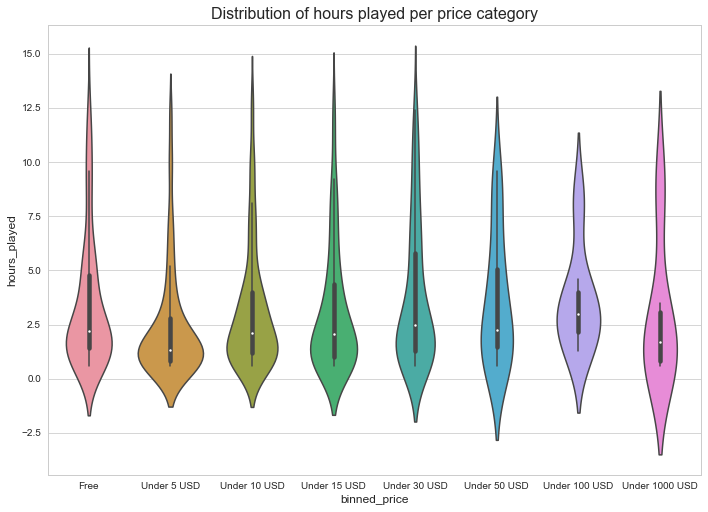

In [171]:
ax = sns.violinplot(x=cbc3_out['binned_price'], y=cbc3_out['hours_played'], data=cbc3_out)
ax.set_title('Distribution of hours played per price category', fontsize=16);

Interestingly enough, Free games have more hours played than very cheap ones. That is because some free to play games are focused on attracting palyers who play long on-line parties. 

In [173]:
cbc3_out1 = remove_outlier(df_cbc3, 'nb_purchases')

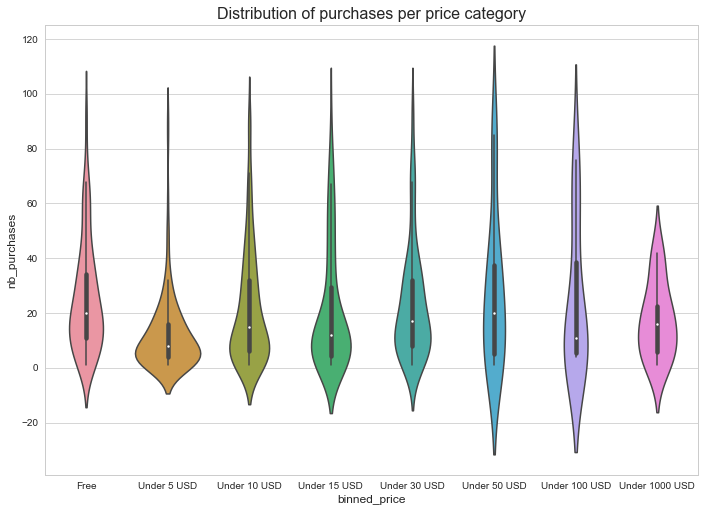

In [178]:
ax = sns.violinplot(x=cbc3_out1['binned_price'], y=cbc3_out1['nb_purchases'], data=cbc3_out1)
ax.set_title('Distribution of purchases per price category', fontsize=16);

Free games attarct more downloads tahn otehr games (surprise:)), and super expensive games are bought quite rarely. That's all obvious.\
Cheap games, however, have quite low median number of purchases. They represent the indie market sub-segment, with low makrekting spend and low hopes...

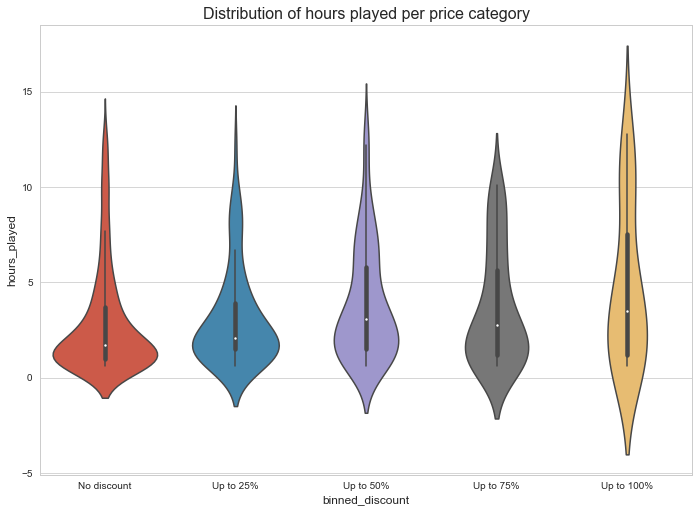

In [176]:
ax = sns.violinplot(x=cbc3_out['binned_discount'], y=cbc3_out['hours_played'], data=cbc3_out)
ax.set_title('Distribution of hours played per price category', fontsize=16);

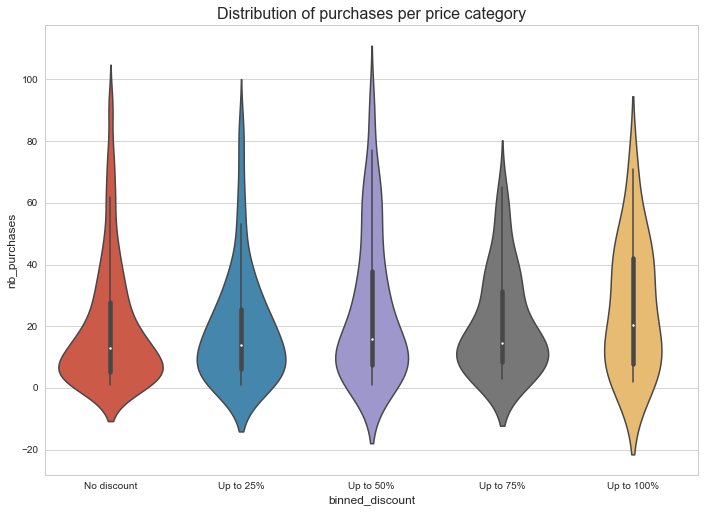

In [182]:
ax = sns.violinplot(x=cbc3_out1['binned_discount'], y=cbc3_out1['nb_purchases'], data=cbc3_out1)
ax.set_title('Distribution of purchases per price category', fontsize=16);

Increasing the discount doesn't seem to change distribution of purchases drastically. While the tails grow "fatter", median values are lower than you would expect

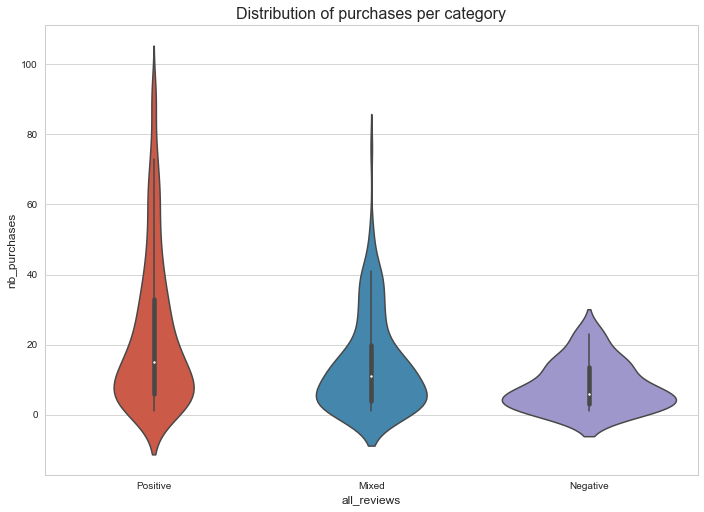

In [183]:
ax = sns.violinplot(x=cbc3_out1['all_reviews'], y=cbc3_out1['nb_purchases'], data=cbc3_out1)
ax.set_title('Distribution of purchases per category', fontsize=16);

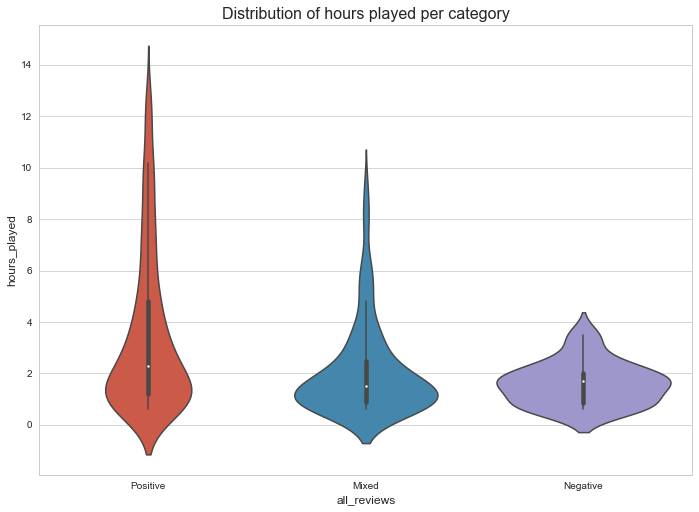

In [184]:
ax = sns.violinplot(x=cbc3_out['all_reviews'], y=cbc3_out['hours_played'], data=cbc3_out1)
ax.set_title('Distribution of hours played per category', fontsize=16);

No surprises here. Bad (at least according to reviews) games are being bought and played less. Reviews matter!

now let's run the model

In [187]:
y3 = df_cbc3['all_reviews']
X3 = df_cbc3.drop(['all_reviews'], axis = 1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.33, random_state=42)

In [188]:
model, params = train_best_model(
    X_train3, y_train3, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params), file=sys.stdout)

best params are {'learning_rate': 0.4234185321620083, 'depth': 5, 'l2_leaf_reg': 9.464266235679002, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}


In [191]:
y_preds3 = model.predict(X_test3)

In [192]:
accuracy = sklearn.metrics.accuracy_score(y_preds3, y_test3)
accuracy

0.7651245551601423

It a VERY bad habit to compare 3 models that we have because they are build on different data and even different classes\
However, let's just visualize them near each other

In [199]:
print("\nFirst run, only second dataset, all classes") 
print(metrics.classification_report(y_test, y_preds))
print("\nSecond run, only second dataset, reduced classes") 
print(metrics.classification_report(y_test2, y_preds2))
print("\nThird run, merged datasets reduced classes") 
print(metrics.classification_report(y_test3, y_preds3))


First run, only second dataset, all classes
                         precision    recall  f1-score   support

                  Mixed       0.39      0.59      0.47      1456
        Mostly Negative       0.25      0.01      0.02       225
        Mostly Positive       0.29      0.04      0.08      1007
               Negative       0.00      0.00      0.00        47
Overwhelmingly Negative       0.00      0.00      0.00         3
Overwhelmingly Positive       0.00      0.00      0.00       111
               Positive       0.46      0.47      0.46      1159
          Very Negative       0.00      0.00      0.00         8
          Very Positive       0.47      0.61      0.53      1445

               accuracy                           0.43      5461
              macro avg       0.21      0.19      0.17      5461
           weighted avg       0.39      0.43      0.38      5461


Second run, only second dataset, reduced classes
              precision    recall  f1-score   support

  

# Part 1 closing remarks

It is clear, that the more classes are unbalanced, the more overfitiing we get, the less appropriate it becomes to rely on the model\
Moreover, in cases of merging we lost a lot of data because of naming inconsistency\
All in all, in a real life situation I would go with first or second runs, leaving the third run alone\
Next steps now are to try to add more features derived from previously removed text fields\
Stay tuned for part2!\
There we will extract features from text and try to tackle imbalanced classes problem using SMOTE